In [1]:
import torch

from matplotlib import pyplot as plt

from lafomo.plot import plot_phase, Colours
from lafomo.utilities.torch import inv_softplus, softplus
from lafomo.datasets import DeterministicLotkaVolterra
from experiments.lotka import build_lotka, plot_lotka
from lafomo.configuration import VariationalConfiguration
from lafomo.trainers import VariationalTrainer
import numpy as np

f64 = np.float64

Lotka-Voltera is in greek mode.
Creating dataset...
Lotka-Voltera is in greek mode.
Creating dataset...
Lotka-Voltera is in greek mode.
Creating dataset...
Lotka-Voltera is in greek mode.
Creating dataset...
Lotka-Voltera is in greek mode.
Creating dataset...


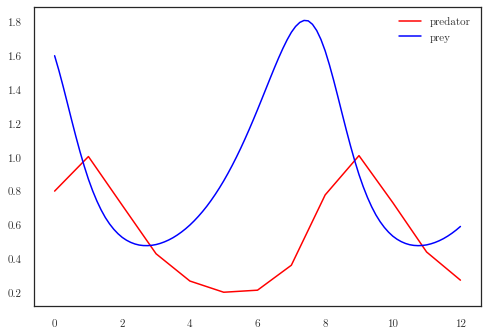

In [39]:
datasets = [DeterministicLotkaVolterra(
    alpha = 2./3,
    beta = 4./3,
    gamma = 1.,
    delta = 1.,
    steps=13,
    end_time=12,
    fixed_initial=i
) for i in [j*0.8 for j in range(1, 6)]]
dataset = datasets[0]
x_min, x_max = min(dataset.times), max(dataset.times)
plt.plot(dataset.data[0][0], dataset.data[0][1], c='red', label='predator')
plt.plot(torch.linspace(x_min, x_max, dataset.prey.shape[0]), dataset.prey, c='blue', label='prey')
plt.legend()
num_latents = 1
num_outputs = 1
num_training = dataset[0][0].shape[0]

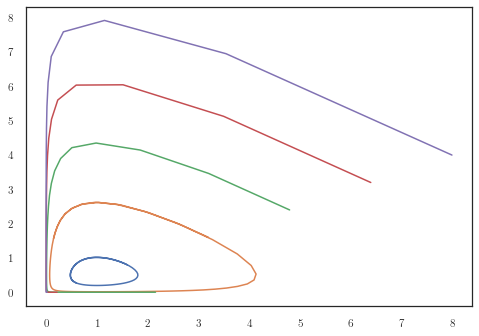

In [40]:
plt.figure()
for dataset in datasets:
    real_prey, real_pred = dataset.prey, dataset.predator
    plt.plot(real_prey, real_pred)

In [3]:
params = dict(
    natural=False,
    kernel='periodic'
)
lfm, trainer, plotter = build_lotka(
    dataset, params,
    reload='../../../experiments/lotka/lotka/0savedmodel'
    # reload='./twentyinducing'
)


Num training points:  13
tensor([[[0.6931]]], grad_fn=<SoftplusBackward>)
torch.Size([70, 1, 33])


/Users/jacob/Documents/proj/reggae/lafomo/models/variational_lfm.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


In [4]:
#trainer.train(400, report_interval=10, step_size=1e-1)

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


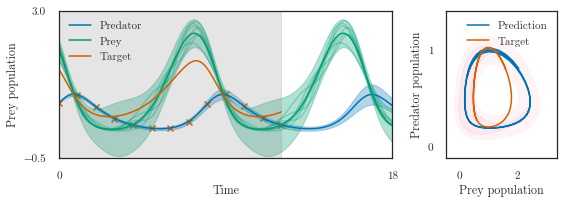

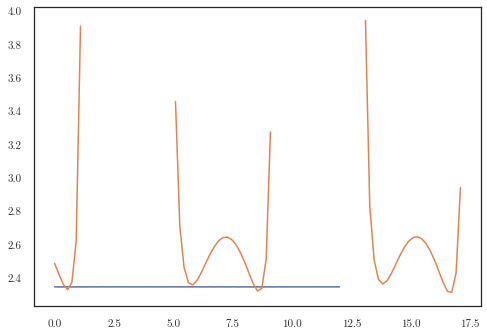

In [5]:
from pathlib import Path
# plt.style.use('seaborn-white')
plot_lotka(dataset, lfm, trainer, plotter, Path('./'), params)
plt.savefig('1.2periodic-combined.pdf')
# lfm.save('./twentyinducing')

In [ ]:
v_targ = dataset.delta * real_prey - dataset.gamma * torch.log(real_prey) + dataset.beta * real_pred - dataset.alpha * torch.log(real_pred)
v_pred = dataset.delta * prey_mean - dataset.gamma * torch.log(prey_mean) + dataset.beta * predator_mean - dataset.alpha * torch.log(predator_mean)

plt.figure()
plt.plot(torch.linspace(0, 12, v_targ.shape[0]), v_targ, label='Target')
plt.plot(t_predict, v_pred, label='Prediction')

In [9]:
with torch.no_grad():
    lfm.raw_decay += 0.3
    lfm.raw_growth += 0.3
print(lfm.decay_rate, lfm.growth_rate)
print(dict(lfm.gp_model.mean_module.named_parameters()))

tensor([[0.8209]], dtype=torch.float64) tensor([[0.7084]], dtype=torch.float64)
{'constant': Parameter containing:
tensor([[0.4244]], dtype=torch.float64)}


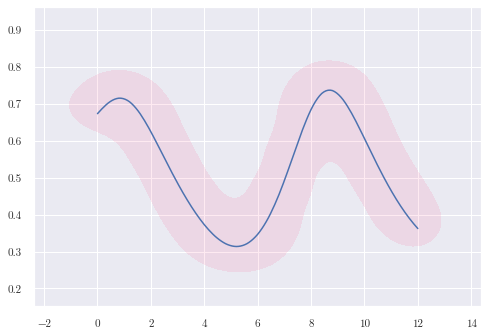

In [39]:
kdeplot(x=t_predict.repeat(50), y=y_samples.flatten(), fill=True, color='pink', alpha=0.1, levels=2, thresh=.1,)
plt.plot(t_predict, predator.mean.detach())